In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import numpy as np

In [2]:
AVOGADROS_NUMBER = 6.022140857e23
HARTREE_TO_EV = 27.211386024367243
EV_TO_JOULE = 1.6021766208e-19
JOULE_TO_KCAL = 1 / 4184.0
HARTREE_TO_JOULE = HARTREE_TO_EV * EV_TO_JOULE
HARTREE_TO_KCALPERMOL = HARTREE_TO_JOULE * JOULE_TO_KCAL * AVOGADROS_NUMBER

def hartree2kcalpermol(x):
    r"""Hartree to kJ/mol conversion factor from CODATA 2014"""
    return x * HARTREE_TO_KCALPERMOL

In [3]:
atom_types = {1: "H", 6: "C", 7: "N", 8: "O"}

df = pd.read_parquet('2xr_comp6v1_energies-forces_full.pq')

df["n_atoms"] = df["species"].apply(len)

df["energy_mean"] = df["energy_mean"].apply(hartree2kcalpermol)
df["energy_qbc"] = df["energy_qbc"].apply(hartree2kcalpermol)
df["dataset_energy"] = df["dataset_energy"].apply(hartree2kcalpermol)

df["atomic_energies"] = df["atomic_energies"].apply(lambda x: [hartree2kcalpermol(e) for e in x])
df["mean_atomic_energies"] = df["mean_atomic_energies"].apply(lambda x: [hartree2kcalpermol(e) for e in x])
df["stdev_atomic_energies"] = df["stdev_atomic_energies"].apply(lambda x: [hartree2kcalpermol(e) for e in x])

df["force_magnitudes"] = df["force_magnitudes"].apply(lambda x: [hartree2kcalpermol(f) for f in x])
df["mean_force_mag"] = df["force_magnitudes"].apply(lambda x: np.mean(np.array(x), axis=0))
df["dataset_force_magnitudes"] = df["dataset_force_magnitudes"].apply(lambda x: [hartree2kcalpermol(f) for f in x])
df["force_magnitude_difference"] = df.apply(lambda row: np.array(row["dataset_force_magnitudes"]) - np.array(row["mean_force_mag"]), axis=1)


df['energy_error'] = abs(df['dataset_energy']-df['energy_mean'])
df["size_weighted_energy_error"] = df["energy_error"] / np.sqrt(df["n_atoms"])
df["weighted_energy_error"] = np.abs(df["dataset_energy"] - df["energy_mean"]) / np.abs(df["dataset_energy"])

print("All energies and forces converted to kcal/mol!")

All energies and forces converted to kcal/mol!


In [4]:
df.iloc[0]

id                                           ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                       [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                   -323365.609936
dataset_force_magnitudes      [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                      -323364.969469
energy_qbc                                                             0.085878
atomic_energies               [[-111.82875645168036, -93.6944355386146, -108...
mean_atomic_energies          [-109.32969109705364, -96.9678350712464, -106....
stdev_atomic_energies         [1.767478557857843, 1.5310178922703555, 1.7671...
force_magnitudes              [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev          [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range          [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                     

In [5]:
df["mean_abs_force_error"] = df["force_magnitude_difference"].apply(lambda x: np.mean(np.abs(x)))
df["rms_force_error"] = df["force_magnitude_difference"].apply(lambda x: np.sqrt(np.mean(np.square(x))))
df["max_force_error"] = df["force_magnitude_difference"].apply(lambda x: np.max(np.abs(x)))

df

,id,species,dataset_energy,dataset_force_magnitudes,energy_mean,energy_qbc,atomic_energies,mean_atomic_energies,stdev_atomic_energies,force_magnitudes,...,mean_relative_range,n_atoms,mean_force_mag,force_magnitude_difference,energy_error,size_weighted_energy_error,weighted_energy_error,mean_abs_force_error,rms_force_error,max_force_error
0,ANI-BenchMD-wB97X-631Gd/020-0-idx0,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323365.609936,"[44.131484527495964, 26.311531452815576, 25.28...",-323364.969469,0.085878,"[[-111.82875645168036, -93.6944355386146, -108...","[-109.32969109705364, -96.9678350712464, -106....","[1.767478557857843, 1.5310178922703555, 1.7671...","[[48.13783707011457, 25.053826333778574, 28.62...",...,0.132286,20,"[49.098209426839034, 26.852705295719716, 27.36...","[-4.96672489934307, -0.54117384290414, -2.0778...",0.640466,0.143213,1.980626e-06,1.797681,2.509415,7.041114
1,ANI-BenchMD-wB97X-631Gd/020-0-idx1,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323375.401484,"[39.90579449573383, 42.71410354908396, 22.6242...",-323375.655208,0.070091,"[[-110.46003142350744, -95.60623521537715, -10...","[-107.85023602895926, -99.04126021161666, -104...","[1.8583971181367842, 1.5919941607443542, 1.852...","[[41.20083663971648, 41.5673435342243, 22.2996...",...,0.137974,20,"[40.33422879207558, 42.45017646049604, 21.0378...","[-0.4284342963417487, 0.2639270885879199, 1.58...",0.253724,0.056735,7.846128e-07,1.158567,1.649767,4.837680
2,ANI-BenchMD-wB97X-631Gd/020-0-idx2,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323370.103359,"[32.39333588265067, 27.210584197994482, 17.293...",-323368.799483,0.100496,"[[-110.66432376535882, -95.05239800337343, -10...","[-108.30804237540029, -98.90967828949415, -103...","[1.7087952366880994, 1.7125199976524605, 1.912...","[[32.24353194015179, 28.140080223655932, 15.75...",...,0.165097,20,"[31.849792534242493, 30.179880242942655, 13.98...","[0.5435433484081749, -2.969296044948173, 3.307...",1.303876,0.291555,4.032147e-06,1.539184,2.046024,3.784925
3,ANI-BenchMD-wB97X-631Gd/020-0-idx3,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323369.378915,"[55.316195699334884, 20.85518530750392, 38.170...",-323369.986787,0.059467,"[[-110.49992116766425, -96.46066680276978, -10...","[-108.41518177731045, -99.73226166577611, -104...","[1.5903142634521197, 1.4938570680669585, 1.789...","[[52.511257544430265, 23.049242794186195, 45.7...",...,0.148786,20,"[53.57104802874761, 21.44341804400239, 41.6662...","[1.7451476705872722, -0.588232736498469, -3.49...",0.607873,0.135924,1.879809e-06,1.381724,2.019308,5.923866
4,ANI-BenchMD-wB97X-631Gd/020-0-idx4,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",-323373.288524,"[44.80066631030287, 12.986574442537334, 34.206...",-323373.203999,0.058624,"[[-112.57880707001004, -97.19162345542478, -10...","[-109.826994461619, -100.4074699230577, -105.1...","[1.865836120618208, 1.5003316417758965, 1.8341...","[[45.07104883304979, 11.481864519133643, 37.37...",...,0.181190,20,"[46.30296728027515, 12.211893707185133, 35.621...","[-1.502300969972275, 0.7746807353522005, -1.41...",0.084525,0.018900,2.613855e-07,1.231651,1.610263,4.839078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101347,GDB13-13-wB97X-631Gd/038-0-idx19,"[6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 1, 1, ...",-351292.843214,"[56.38688374663998, 99.01833249181533, 51.8240...",-351289.983660,0.258743,"[[-200.2228211965641, -118.98179360242513, -20...","[-185.75309234696567, -115.03238165920712, -18...","[7.350083931062285, 3.6362328023774073, 6.9727...","[[58.42408458582331, 100.16477458560107, 53.21...",...,0.127471,38,"[55.53663656161731, 97.40338460485826, 52.3234...","[0.850247185022674, 1.6149478869570686, -0.499...",2.859553,0.463881,8.140085e-06,2.864684,4.147525,11.782889
101348,GDB13-13-wB97X-631Gd/038-0-idx20,"[6, 7, 6, 6, 6, 6, 6, 7, 6, 6, 6, 6, 7, 1, 1, ...",-351447.549823,"[58.203288399987684, 38.367510003035, 89.07974...",-351446.24822

In [6]:
len(df)

101352

In [7]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (6.5, 4)
plt.rcParams["figure.dpi"] = 150

2608858
R²: 0.9839


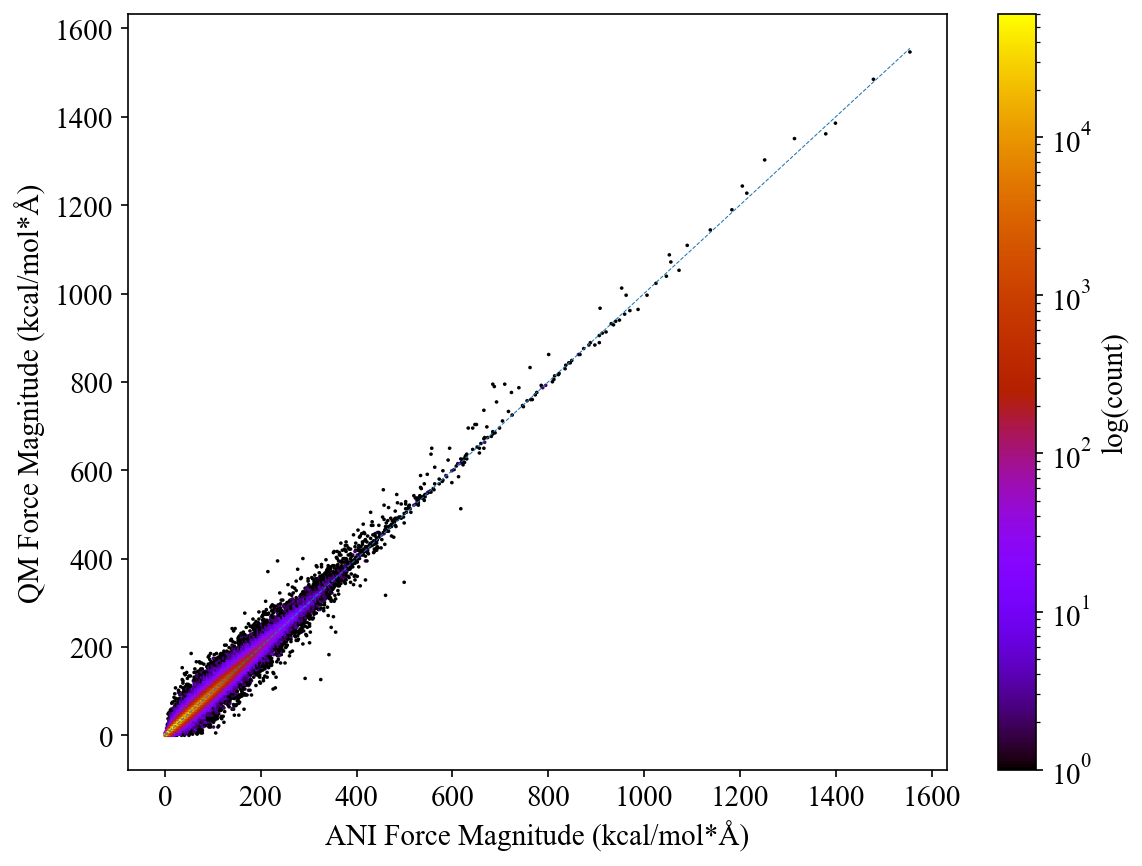

In [10]:
import numpy as np


force_pairs = [
    (pred, ref)
    for pred_list, ref_list in zip(df["mean_force_mag"], df["dataset_force_magnitudes"])
    for pred, ref in zip(pred_list, ref_list)  # Unpacking per atom
]

print(len(force_pairs))

pred_forces, ref_forces = map(np.array, zip(*force_pairs))

# Manual R² calculation
ss_res = np.sum((ref_forces - pred_forces)**2)
ss_tot = np.sum((ref_forces - np.mean(ref_forces))**2)
r2 = 1 - (ss_res / ss_tot)

print(f"R²: {r2:.4f}")

plt.figure(figsize=(8,6))
plt.hexbin(pred_forces, ref_forces, gridsize=500, cmap="gnuplot", bins="log")
plt.colorbar(label="log(count)")


plt.xlabel("ANI Force Magnitude (kcal/mol*Å)")
plt.ylabel("QM Force Magnitude (kcal/mol*Å)")
#plt.title("Predicted vs. Dataset Force Magnitudes (Density)")

min_force, max_force = min(pred_forces), max(pred_forces)
plt.plot([min_force, max_force], [min_force, max_force], linewidth=0.5, linestyle="--")
plt.tight_layout()
plt.savefig('./figures/forces/2xr_comp6v1_force-dft-vs-mean_ani.png')

plt.show()


Number of force pairs within [0,400] range: 2608492


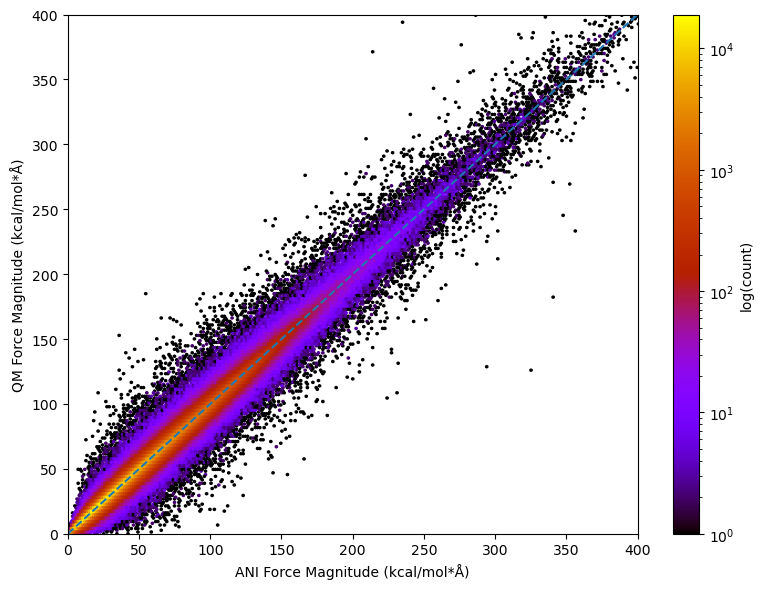

In [7]:
in_range_count = np.sum((pred_forces >= 0) & (pred_forces <= 400) & 
                        (ref_forces >= 0) & (ref_forces <= 400))

print(f"Number of force pairs within [0,400] range: {in_range_count}")

plt.figure(figsize=(8,6))
plt.hexbin(pred_forces, ref_forces, gridsize=1000, cmap="gnuplot", bins="log")
plt.colorbar(label="log(count)")

plt.xlabel("ANI Force Magnitude (kcal/mol*Å)")
plt.ylabel("QM Force Magnitude (kcal/mol*Å)")

# Set the axis limits to zoom in on 0-400 range
plt.xlim(0, 400)
plt.ylim(0, 400)

# Adjust the diagonal reference line to match the new range
plt.plot([0, 400], [0, 400], linewidth=1.5, linestyle="--")

plt.tight_layout()
plt.savefig('./figures/forces/zoomed_2xr_comp6v1_force-dft-vs-mean_ani.png')

plt.show()

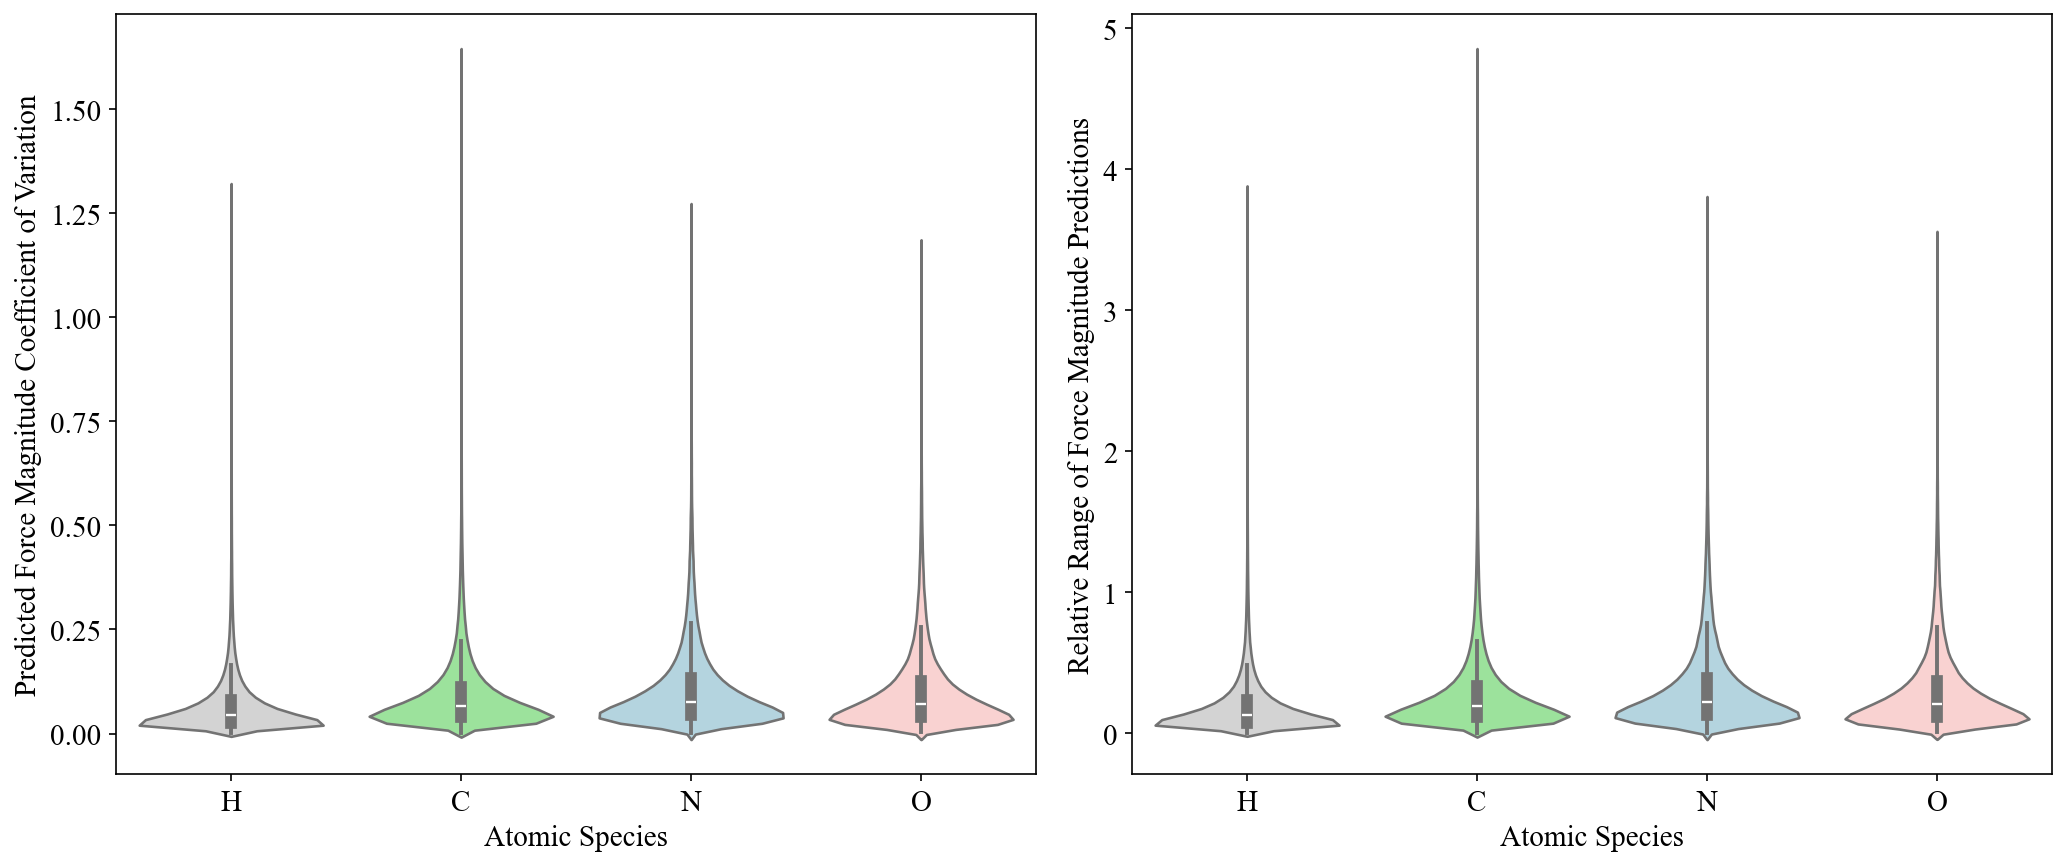

In [16]:
atom_types_colors = {
    1: ("H", "#d3d3d3"),   # Light Grey
    6: ("C", "#90ee90"),   # Light Green
    7: ("N", "#add8e6"),   # Light Blue
    8: ("O", "#ffcccb")    # Light Red
}
df_long_stdev = df.explode("force_relative_stdev").reset_index(drop=True)
df_long_stdev["species"] = df.explode("species")["species"].reset_index(drop=True)
df_long_stdev["species"] = df_long_stdev["species"].map(lambda x: atom_types_colors.get(x, ("Unknown", "black"))[0])

df_long_range = df.explode("force_relative_range").reset_index(drop=True)
df_long_range["species"] = df.explode("species")["species"].reset_index(drop=True)
df_long_range["species"] = df_long_range["species"].map(lambda x: atom_types_colors.get(x, ("Unknown", "black"))[0])

species_color_map = {v[0]: v[1] for v in atom_types_colors.values()}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.violinplot(ax=axes[0], data=df_long_stdev, x="species", y="force_relative_stdev", 
               hue="species", palette=species_color_map, order=['H', 'C', 'N', 'O'])

axes[0].set_xlabel("Atomic Species")
axes[0].set_ylabel("Predicted Force Magnitude Coefficient of Variation")
#axes[0].set_title("Relative Standard Deviation of Force Predictions by Element")

sns.violinplot(ax=axes[1], data=df_long_range, x="species", y="force_relative_range", 
               hue="species", palette=species_color_map, order=['H', 'C', 'N', 'O'])

axes[1].set_xlabel("Atomic Species")
axes[1].set_ylabel("Relative Range of Force Magnitude Predictions")
#axes[1].set_title("Relative Range of Force Predictions by Element")
plt.savefig('./figures/forces/2xr_comp6v1_force-uncertainty_violin.png')


plt.tight_layout()
plt.show()

In [24]:
df_long_stdev[df_long_stdev['species'] == 'O']

,id,species,dataset_energy,dataset_force_magnitudes,energy_mean,energy_qbc,atomic_energies,mean_atomic_energies,stdev_atomic_energies,force_magnitudes,...,mean_relative_range,n_atoms,mean_force_mag,force_magnitude_difference,energy_error,size_weighted_energy_error,weighted_energy_error,mean_abs_force_error,rms_force_error,max_force_error
0,ANI-BenchMD-wB97X-631Gd/020-0-idx0,O,-323365.609936,"[44.131484527495964, 26.311531452815576, 25.28...",-323364.969469,0.085878,"[[-111.82875645168036, -93.6944355386146, -108...","[-109.32969109705364, -96.9678350712464, -106....","[1.767478557857843, 1.5310178922703555, 1.7671...","[[48.13783707011457, 25.053826333778574, 28.62...",...,0.132286,20,"[49.098209426839034, 26.852705295719716, 27.36...","[-4.96672489934307, -0.54117384290414, -2.0778...",0.640466,0.143213,1.980626e-06,1.797681,2.509415,7.041114
1,ANI-BenchMD-wB97X-631Gd/020-0-idx0,O,-323365.609936,"[44.131484527495964, 26.311531452815576, 25.28...",-323364.969469,0.085878,"[[-111.82875645168036, -93.6944355386146, -108...","[-109.32969109705364, -96.9678350712464, -106....","[1.767478557857843, 1.5310178922703555, 1.7671...","[[48.13783707011457, 25.053826333778574, 28.62...",...,0.132286,20,"[49.098209426839034, 26.852705295719716, 27.36...","[-4.96672489934307, -0.54117384290414, -2.0778...",0.640466,0.143213,1.980626e-06,1.797681,2.509415,7.041114
20,ANI-BenchMD-wB97X-631Gd/020-0-idx1,O,-323375.401484,"[39.90579449573383, 42.71410354908396, 22.6242...",-323375.655208,0.070091,"[[-110.46003142350744, -95.60623521537715, -10...","[-107.85023602895926, -99.04126021161666, -104...","[1.8583971181367842, 1.5919941607443542, 1.852...","[[41.20083663971648, 41.5673435342243, 22.2996...",...,0.137974,20,"[40.33422879207558, 42.45017646049604, 21.0378...","[-0.4284342963417487, 0.2639270885879199, 1.58...",0.253724,0.056735,7.846128e-07,1.158567,1.649767,4.837680
21,ANI-BenchMD-wB97X-631Gd/020-0-idx1,O,-323375.401484,"[39.90579449573383, 42.71410354908396, 22.6242...",-323375.655208,0.070091,"[[-110.46003142350744, -95.60623521537715, -10...","[-107.85023602895926, -99.04126021161666, -104...","[1.8583971181367842, 1.5919941607443542, 1.852...","[[41.20083663971648, 41.5673435342243, 22.2996...",...,0.137974,20,"[40.33422879207558, 42.45017646049604, 21.0378...","[-0.4284342963417487, 0.2639270885879199, 1.58...",0.253724,0.056735,7.846128e-07,1.158567,1.649767,4.837680
40,ANI-BenchMD-wB97X-631Gd/020-0-idx2,O,-323370.103359,"[32.39333588265067, 27.210584197994482, 17.293...",-323368.799483,0.100496,"[[-110.66432376535882, -95.05239800337343, -10...","[-108.30804237540029, -98.90967828949415, -103...","[1.7087952366880994, 1.7125199976524605, 1.912...","[[32.24353194015179, 28.140080223655932, 15.75...",...,0.165097,20,"[31.849792534242493, 30.179880242942655, 13.98...","[0.5435433484081749, -2.969296044948173, 3.307...",1.303876,0.291555,4.032147e-06,1.539184,2.046024,3.784925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2606977,GDB13-13-wB97X-631Gd/035-0-idx57,O,-365357.517220,"[95.60996611268578, 67.745011513681, 85.236687...",-365356.322432,0.489941,"[[-207.2581153425216, -197.4330076692201, -157...","[-190.79644265367395, -187.39969909498203, -14...","[8.924098310925011, 4.89291373633713, 4.684009...","[[81.84996800874845, 67.42611797530223, 89.372...",...,0.135874,35,"[88.56994522840871, 74.62256596298019, 88.6177...","[7.0400208842770695, -6.877554449299183, -3.38...",1.194788,0.201956,3.270189e-06,2.877555,3.647014,8.969965
2607010,GDB13-13-wB97X-631Gd/035-0-idx58,O,-365444.383445,"[101.20159001260423, 147.60024452316364, 74.13...",-365448.855568,0.310959,"[[-196.28074948990565, -194.72820997728957, -2...","[-183.6766189045337, -185.58973701869107, -190...","[6.942437815824059, 4.540988549026576, 8.82721...","[[106.21593469662747, 150.40052139408746, 73.8...",...,0.097562,35,"[105.0735133693648, 151.38885853262815, 74.733...","[-3.8719233567605755, -3.78861400946451, -0.60...",4.47212

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define weight function (exponential to emphasize high-force atoms)
def compute_weighted_average(values, weights, alpha=1.0):
    """Compute weighted mean with exponential weighting."""
    exp_weights = np.exp(alpha * np.array(weights))  # Exponential weighting
    return np.sum(np.array(values) * exp_weights) / np.sum(exp_weights)

# Compute weighted averages for each molecule
weighted_stdev = []
weighted_range = []

for _, row in df.iterrows():
    # Compute weighted averages using force magnitudes as weights
    weighted_stdev.append(compute_weighted_average(row["force_relative_stdev"], row["mean_force_mag"], alpha=2))
    weighted_range.append(compute_weighted_average(row["force_relative_range"], row["mean_force_mag"], alpha=2))

# Store in DataFrame
df["weighted_force_stdev"] = weighted_stdev
df["weighted_force_range"] = weighted_range

stdev_correlation_error = df['size_weighted_energy_error'].corr(df['weighted_force_stdev'])
print(f"Correlation between total energy error and weighted force relative stdev: {stdev_correlation_error:.3f}")
range_correlation_error = df['size_weighted_energy_error'].corr(df['weighted_force_range'])
print(f"Correlation between total energy error and weighted force relative stdev: {range_correlation_error:.3f}")

/var/folders/gg/d8ll1f157js5d4n67jyq89jr0000gn/T/ipykernel_4088/2008092633.py:8: RuntimeWarning: overflow encountered in exp
  exp_weights = np.exp(alpha * np.array(weights))  # Exponential weighting
/var/folders/gg/d8ll1f157js5d4n67jyq89jr0000gn/T/ipykernel_4088/2008092633.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(np.array(values) * exp_weights) / np.sum(exp_weights)


Correlation between total energy error and weighted force relative stdev: 0.094
Correlation between total energy error and weighted force relative stdev: 0.092


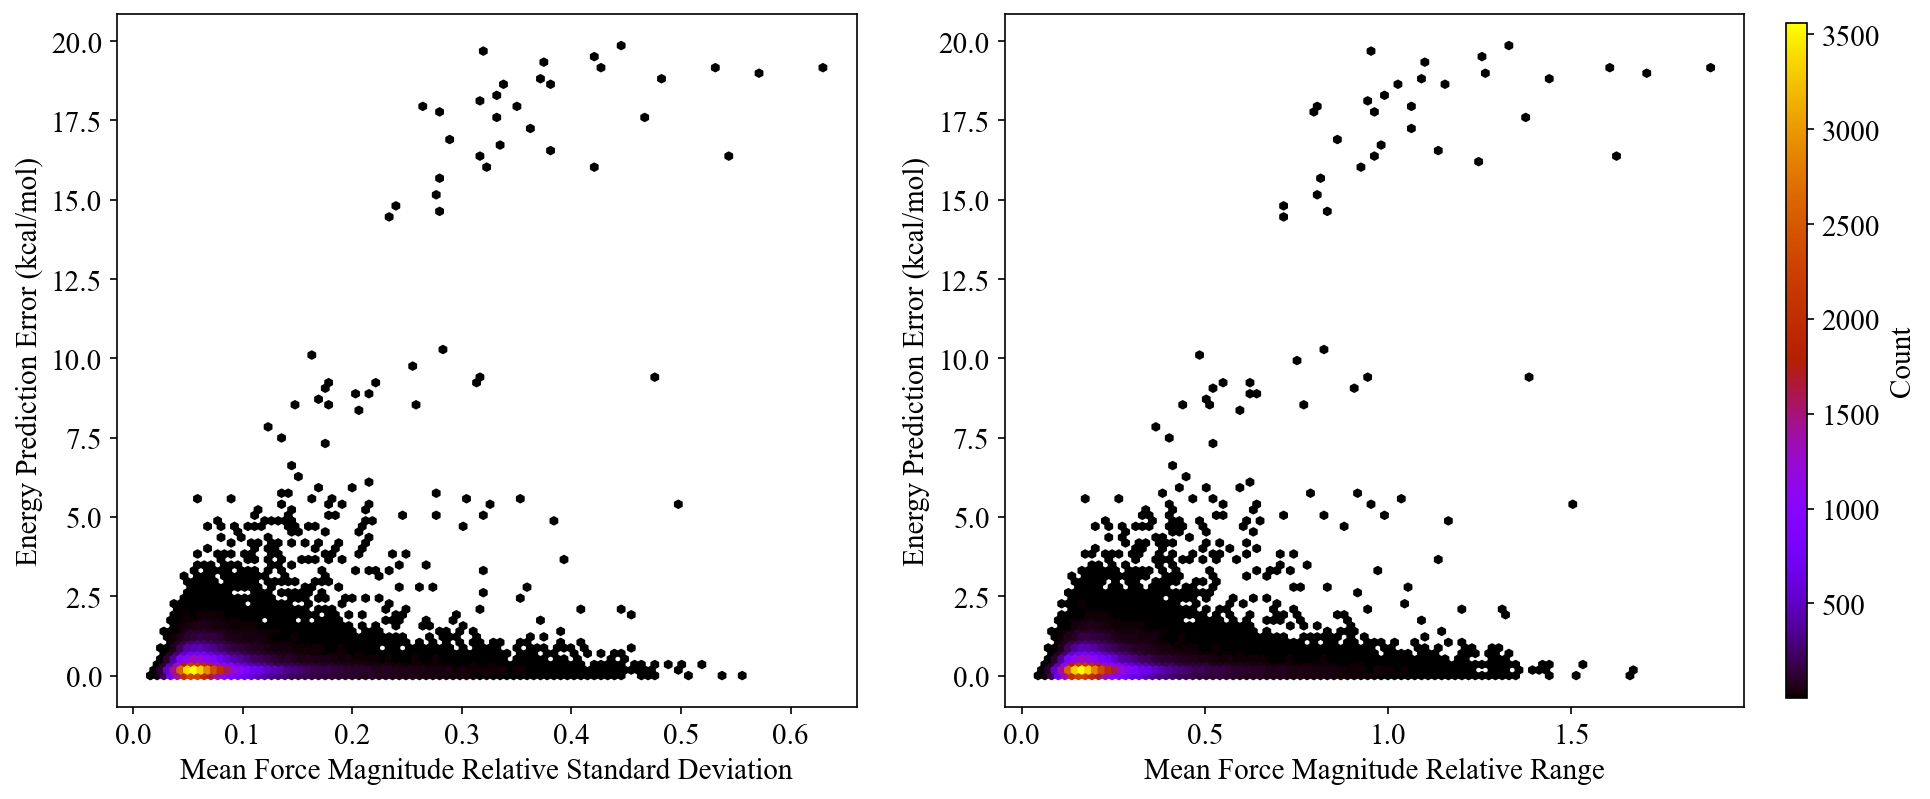

In [25]:
x_stdev = df["mean_relative_stdev"]
x_range = df["mean_relative_range"]
y_error = df["size_weighted_energy_error"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

hb1 = axes[0].hexbin(x_stdev, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[0].set_xlabel("Mean Force Magnitude Relative Standard Deviation")
axes[0].set_ylabel("Energy Prediction Error (kcal/mol)")
#axes[0].set_title("Weighted Force Stdev vs. Energy Error")
#cb1.set_label("Bin Count")

hb2 = axes[1].hexbin(x_range, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[1].set_xlabel("Mean Force Magnitude Relative Range")
axes[1].set_ylabel("Energy Prediction Error (kcal/mol)")
#axes[1].set_title("Weighted Force Range vs. Energy Error")
cbar_ax = fig.add_axes([0.92, 0.12, 0.01, 0.75])  # [left, bottom, width, height]
cbar = fig.colorbar(hb1, cax=cbar_ax)
cbar.set_label("Count")
#cb2.set_label("Bin Count")

#plt.tight_layout()
plt.savefig('./figures/forces/mean-uncertainty-vs-energy.png')
plt.show()


/var/folders/gg/d8ll1f157js5d4n67jyq89jr0000gn/T/ipykernel_4088/2606825065.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


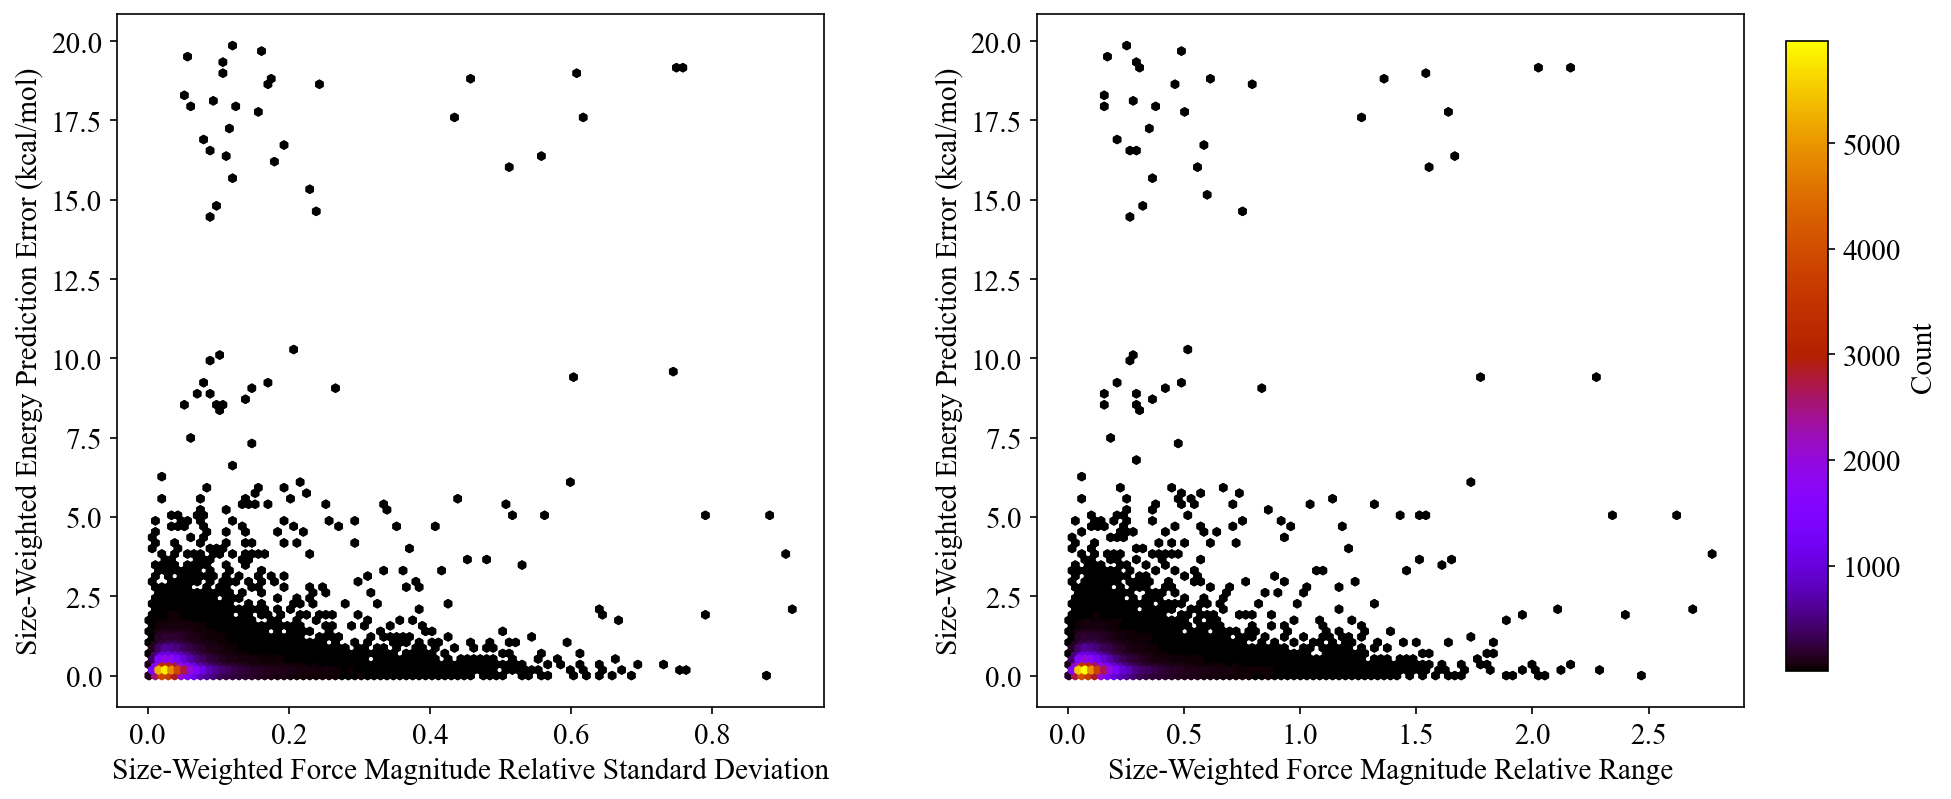

In [35]:
import matplotlib.pyplot as plt

x_stdev = df["weighted_force_stdev"]
x_range = df["weighted_force_range"]
y_error = df["size_weighted_energy_error"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"wspace": 0.3})  # Adjust spacing between subplots

# Compute shared color limits (min/max count across both hexbins)
hb1 = axes[0].hexbin(x_stdev, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
hb2 = axes[1].hexbin(x_range, y_error, gridsize=100, cmap="gnuplot", mincnt=1)

# Get global min/max counts from both hexbin plots
vmin = min(hb1.get_array().min(), hb2.get_array().min())
vmax = max(hb1.get_array().max(), hb2.get_array().max())

# Re-plot with shared color scale
hb1 = axes[0].hexbin(x_stdev, y_error, gridsize=100, cmap="gnuplot", mincnt=1, vmin=vmin, vmax=vmax)
hb2 = axes[1].hexbin(x_range, y_error, gridsize=100, cmap="gnuplot", mincnt=1, vmin=vmin, vmax=vmax)

# Labels
axes[0].set_xlabel("Size-Weighted Force Magnitude Relative Standard Deviation")
axes[0].set_ylabel("Size-Weighted Energy Prediction Error (kcal/mol)")

axes[1].set_xlabel("Size-Weighted Force Magnitude Relative Range")
axes[1].set_ylabel("Size-Weighted Energy Prediction Error (kcal/mol)")

# Create a separate axis for the colorbar, positioned slightly to the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(hb1, cax=cbar_ax)
cbar.set_label("Count")

plt.tight_layout()
plt.savefig('./figures/forces/weighted_uncertainty-vs-size_weighted_error.png')

plt.show()

In [242]:
df['size_weighted_energy_error'].corr(df['weighted_force_stdev'])

np.float64(0.09353948937884406)

In [90]:
df.iloc[0]

id                                           ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                       [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                   -323365.609936
dataset_force_magnitudes      [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                      -323364.969469
energy_qbc                                                             0.085878
atomic_energies               [[-111.82875645168036, -93.6944355386146, -108...
mean_atomic_energies          [-109.32969109705364, -96.9678350712464, -106....
stdev_atomic_energies         [1.767478557857843, 1.5310178922703555, 1.7671...
force_magnitudes              [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev          [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range          [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                     

In [163]:
force_correlation_error = df['size_weighted_energy_error'].corr(df['weighted_force_stdev'])
print(f"Correlation between total energy error and weighted force relative stdev: {force_correlation_error:.3f}")

Correlation between total energy error and weighted force relative stdev: 0.085


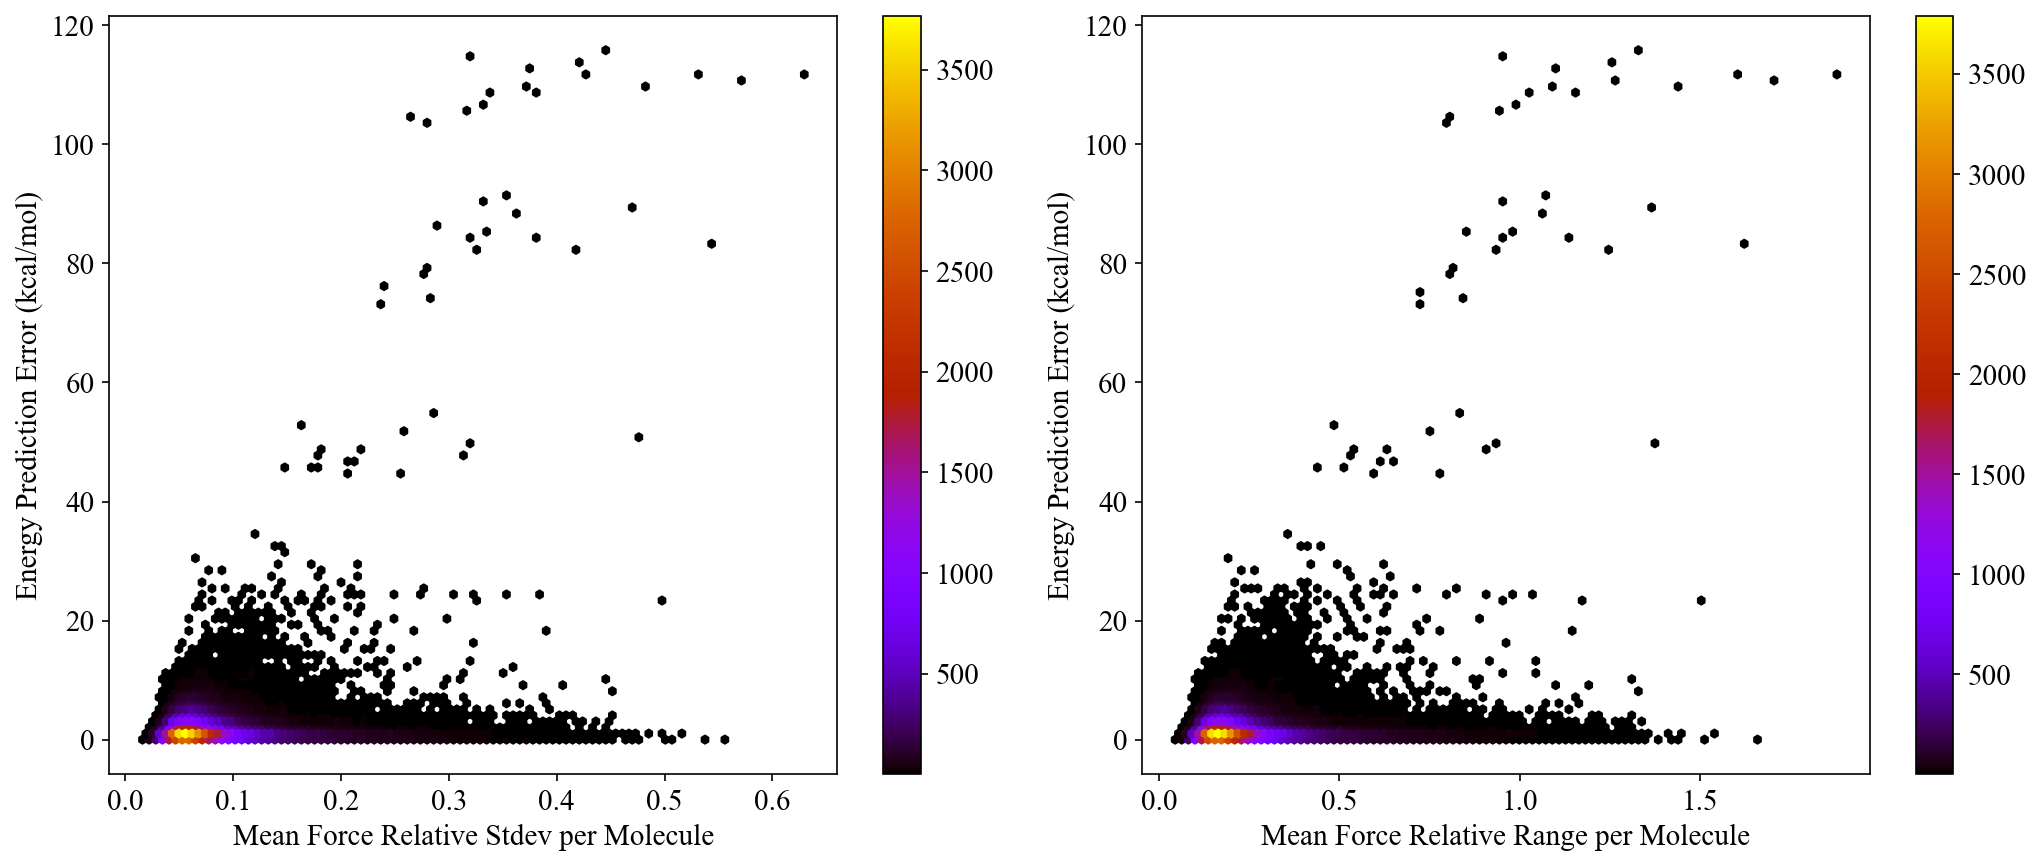

In [20]:
x_stdev = df["mean_relative_stdev"]
x_range = df["mean_relative_range"]
y_error = df["energy_error"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

hb1 = axes[0].hexbin(x_stdev, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[0].set_xlabel("Mean Force Relative Stdev per Molecule")
axes[0].set_ylabel("Energy Prediction Error (kcal/mol)")
#axes[0].set_title("Mean Force Stdev vs. Energy Error")
cb1 = fig.colorbar(hb1, ax=axes[0])
#cb1.set_label("Bin Count")

hb2 = axes[1].hexbin(x_range, y_error, gridsize=100, cmap="gnuplot", mincnt=1)
axes[1].set_xlabel("Mean Force Relative Range per Molecule")
axes[1].set_ylabel("Energy Prediction Error (kcal/mol)")
#axes[1].set_title("Mean Force Range vs. Energy Error")
cb2 = fig.colorbar(hb2, ax=axes[1])
#cb2.set_label("Bin Count")

plt.tight_layout()
plt.savefig('./figures/forces/2xr_comp6v1_force-mean-uncertainty-vs-energ.png')
plt.show()

Correlation between total energy error and max relative force deviation: 0.122


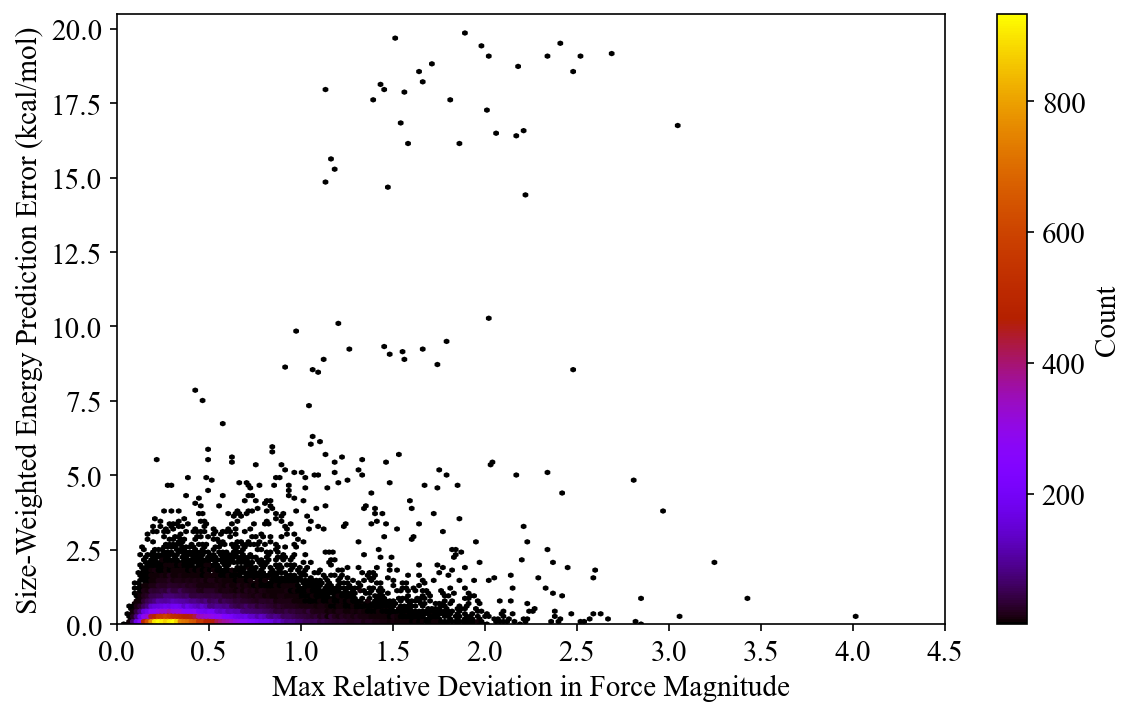

In [30]:
relative_max_deviations = []

for _, row in df.iterrows():
    species = row["species"]  # Atomic species per atom
    force_magnitudes = np.array(row["force_magnitudes"])  # Shape: (8, N_atoms)
    mean_force = np.mean(force_magnitudes, axis=0)  # Mean over ensemble, shape: (N_atoms,)

    mean_force[mean_force == 0] = np.nan  # Set zeros to NaN to avoid division errors

    max_relative_deviation = np.nanmax(np.abs(force_magnitudes - mean_force) / mean_force, axis=0)

    for atom_idx, rel_deviation in enumerate(max_relative_deviation):
        relative_max_deviations.append([
            row["id"], species[atom_idx], rel_deviation, row["size_weighted_energy_error"]
        ])

df_relative_max_dev = pd.DataFrame(
    relative_max_deviations, columns=["id", "species", "max_relative_force_deviation", "size_weighted_energy_error"]
)

df_max_per_molecule = df_relative_max_dev.loc[
    df_relative_max_dev.groupby("id")["max_relative_force_deviation"].idxmax()
]

force_correlation_error = df_max_per_molecule['size_weighted_energy_error'].corr(df_max_per_molecule['max_relative_force_deviation'])
print(f"Correlation between total energy error and max relative force deviation: {force_correlation_error:.3f}")

plt.figure(figsize=(8, 5))
hb = plt.hexbin(
    df_max_per_molecule["max_relative_force_deviation"], 
    df_max_per_molecule["size_weighted_energy_error"], 
    gridsize=200, cmap="gnuplot", mincnt=1
)

plt.xlim(0,4.5)
plt.ylim(0,20.5)

plt.colorbar(hb, label="Count")
plt.xlabel("Max Relative Deviation in Force Magnitude")
plt.ylabel("Size-Weighted Energy Prediction Error (kcal/mol)")
#plt.title("Highest Force Deviation per Molecule vs. Energy Error")
plt.tight_layout()
plt.savefig('./figures/forces/2xr_comp6v1_force-highest-force_deviation-vs-energy.png')
plt.show()


90th percentile of size-weighed energy error threshold: 0.7645974832332655
Correlation between total energy error and max relative force deviation: 0.122


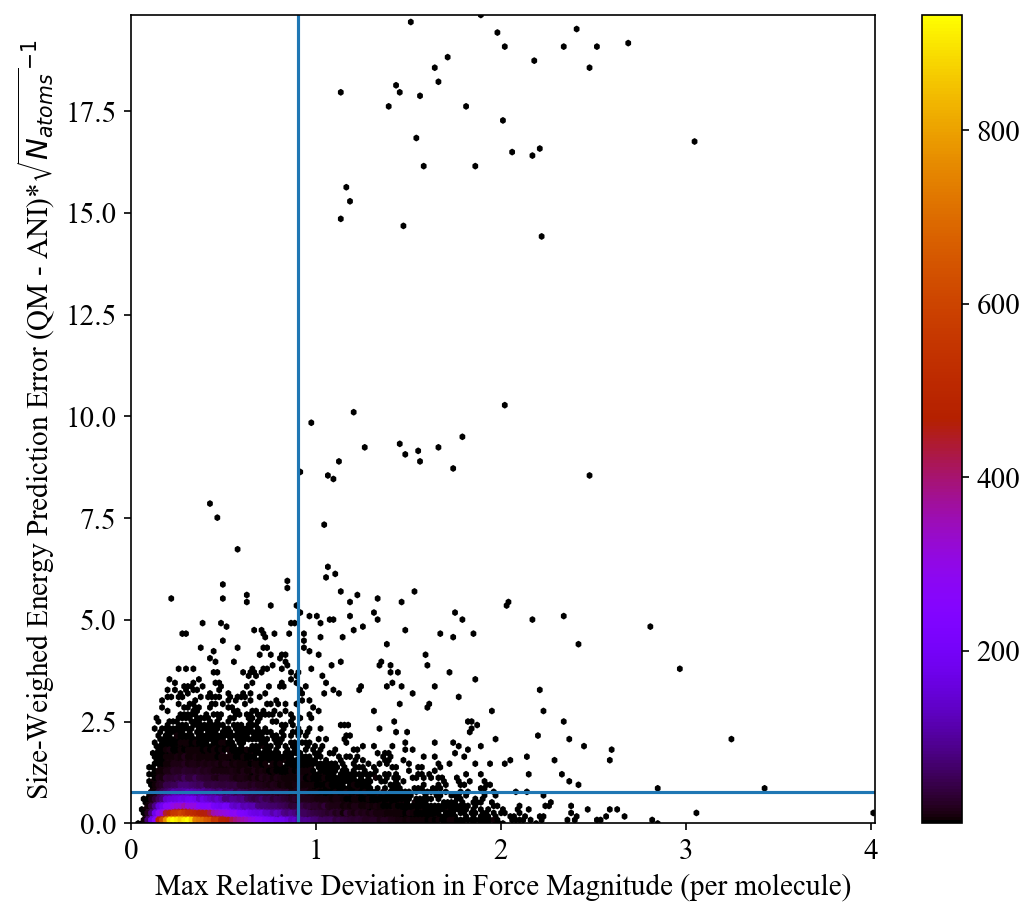

In [38]:
relative_max_deviations = []

for _, row in df.iterrows():
    species = row["species"]  # Atomic species per atom
    force_magnitudes = np.array(row["force_magnitudes"])  # Shape: (8, N_atoms)
    mean_force = np.mean(force_magnitudes, axis=0)  # Mean over ensemble, shape: (N_atoms,)

    mean_force[mean_force == 0] = np.nan  # Set zeros to NaN to avoid division errors

    max_relative_deviation = np.nanmax(np.abs(force_magnitudes - mean_force) / mean_force, axis=0)

    for atom_idx, rel_deviation in enumerate(max_relative_deviation):
        relative_max_deviations.append([
            row["id"], species[atom_idx], rel_deviation, row["size_weighted_energy_error"]
        ])

df_relative_max_dev = pd.DataFrame(
    relative_max_deviations, columns=["id", "species", "max_relative_force_deviation", "size_weighted_energy_error"]
)

df_max_per_molecule = df_relative_max_dev.loc[
    df_relative_max_dev.groupby("id")["max_relative_force_deviation"].idxmax()
]


threshold_90 = np.quantile(df['size_weighted_energy_error'], 0.9)
print("90th percentile of size-weighed energy error threshold:", threshold_90)

x_threshold = 0.9
y_threshold = threshold_90

force_correlation_error = df_max_per_molecule['size_weighted_energy_error'].corr(df_max_per_molecule['max_relative_force_deviation'])
print(f"Correlation between total energy error and max relative force deviation: {force_correlation_error:.3f}")


plt.figure(figsize=(8, 7))
plt.axvline(x=x_threshold)
plt.axhline(y=y_threshold)
plt.xlim(0,max(df_max_per_molecule["max_relative_force_deviation"]))
plt.ylim(0,max(df_max_per_molecule["size_weighted_energy_error"]))
hb = plt.hexbin(
    df_max_per_molecule["max_relative_force_deviation"], 
    df_max_per_molecule["size_weighted_energy_error"], 
    gridsize=200, cmap="gnuplot", mincnt=1,
)

plt.colorbar(hb)#, label="Count in Hexbin")
plt.xlabel("Max Relative Deviation in Force Magnitude (per molecule)")
plt.ylabel(r"Size-Weighed Energy Prediction Error (QM - ANI)*$\sqrt{N_{atoms}}^{-1}$")
#plt.title("Highest Force Deviation per Molecule vs. Weighted Energy Error")

plt.show()


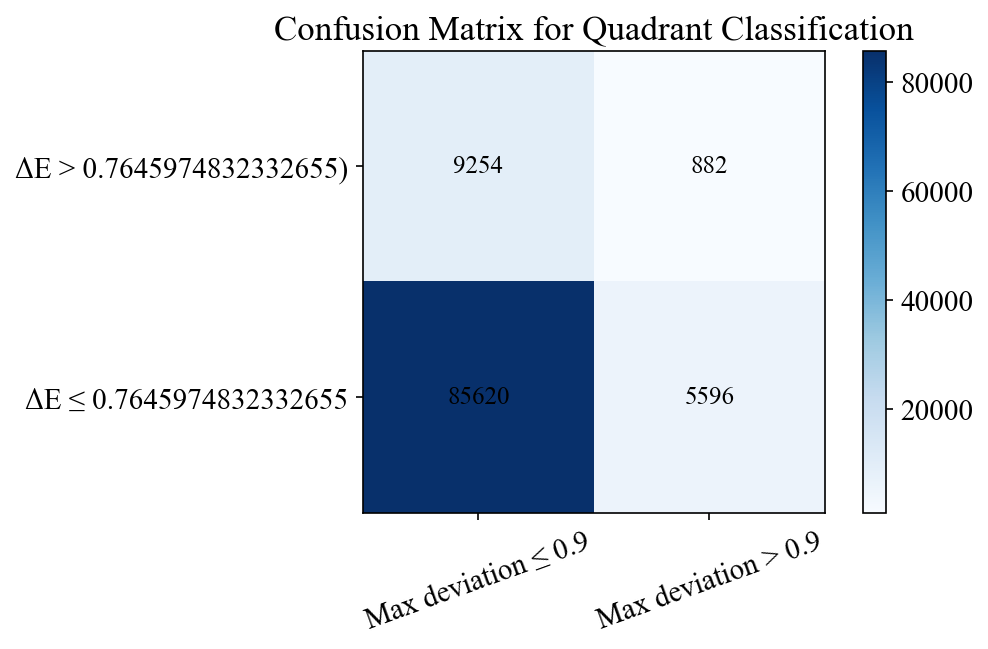

In [39]:
# Load data from df_max_per_molecule
df_max_per_molecule = pd.DataFrame({
    "max_relative_force_deviation": df_relative_max_dev.groupby("id")["max_relative_force_deviation"].max(),
    "size_weighted_energy_error": df_relative_max_dev.groupby("id")["size_weighted_energy_error"].first()
}).reset_index()


# Classify points into quadrants
TP = ((df_max_per_molecule["max_relative_force_deviation"] > x_threshold) & 
      (df_max_per_molecule["size_weighted_energy_error"] > y_threshold)).sum()

FN = ((df_max_per_molecule["max_relative_force_deviation"] <= x_threshold) & 
      (df_max_per_molecule["size_weighted_energy_error"] > y_threshold)).sum()

TN = ((df_max_per_molecule["max_relative_force_deviation"] <= x_threshold) & 
      (df_max_per_molecule["size_weighted_energy_error"] <= y_threshold)).sum()

FP = ((df_max_per_molecule["max_relative_force_deviation"] > x_threshold) & 
      (df_max_per_molecule["size_weighted_energy_error"] <= y_threshold)).sum()


conf_matrix = np.array([[FN, TP], [TN, FP]])

# Define labels corresponding to plot quadrants
categories = ["Above hline (y > 0.1)", "Below hline (y ≤ 0.1)"]
predictions = ["Left of vline (x ≤ 1)", "Right of vline (x > 1)"]

# Plot confusion matrix
fig, ax = plt.subplots()
cax = ax.imshow(conf_matrix, cmap="Blues")

# Add color bar
plt.colorbar(cax)

# Annotate each cell with the count
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", color="black", fontsize=12)

# Set axis labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels([f"Max deviation ≤ {x_threshold}", f"Max deviation > {x_threshold}"])
ax.set_yticklabels([f"ΔE > {y_threshold})", f"ΔE ≤ {y_threshold}"])

# Rotate x-axis labels for readability
plt.xticks(rotation=20)

# Add title
plt.title("Confusion Matrix for Quadrant Classification")

plt.show()

In [40]:
df.iloc[0]

id                                           ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                       [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                   -323365.609936
dataset_force_magnitudes      [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                      -323364.969469
energy_qbc                                                             0.085878
atomic_energies               [[-111.82875645168036, -93.6944355386146, -108...
mean_atomic_energies          [-109.32969109705364, -96.9678350712464, -106....
stdev_atomic_energies         [1.767478557857843, 1.5310178922703555, 1.7671...
force_magnitudes              [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev          [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range          [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                     

In [41]:
def compute_weighted_force_stdev(force_stdev, mean_magnitudes):
    """
    Compute a weighted average of force standard deviations per molecule.

    Parameters:
    - force_stdev: (N_atoms,) list of standard deviations per atom.
    - mean_magnitudes: (N_atoms,) list of mean force magnitudes per atom.

    Returns:
    - A single weighted standard deviation value per molecule.
    """
    force_stdev = np.array(force_stdev)
    mean_magnitudes = np.array(mean_magnitudes)

    # Avoid division by zero
    total_weight = np.sum(mean_magnitudes)
    if total_weight == 0:
        return np.nan  # Return NaN if all weights are zero

    # Compute the weighted mean standard deviation
    weighted_stdev = np.sum(force_stdev * mean_magnitudes) / total_weight
    return weighted_stdev

# Apply the function across the dataframe
df["weighted_force_stdev"] = df.apply(
    lambda row: compute_weighted_force_stdev(row["force_relative_stdev"], row["mean_force_mag"]),
    axis=1
)

# Debug print for first row
print("Weighted force standard deviation for first molecule:", df["weighted_force_stdev"].iloc[0])

print(f"correlation: {df['weighted_force_stdev'].corr(df['size_weighted_energy_error'])}")

Weighted force standard deviation for first molecule: 0.03721137598301259
correlation: 0.09901862883679538


In [42]:
cos_sim = pd.read_parquet('2xr_cos_sim-mag_df-comp6v1.pq')
print(cos_sim.iloc[0])
#cos_sim = cos_sim.reset_index().explode(['Difference', 'Mean Cos Sim', 'Species']).set_index('Species')

Dataset magnitudes    [44.1314811706543, 26.31153106689453, 25.28806...
Members magnitudes    [[48.137840270996094, 25.053823471069336, 28.6...
Mean magnitudes       [49.08607482910156, 26.804031372070312, 27.164...
Stdev magnitudes      [23.241201400756836, 23.09302520751953, 24.211...
Difference            [4.954593658447266, 0.49250030517578125, 1.876...
Cos Sim               [[0.9992108345031738, 0.9948561787605286, 0.98...
Mean Cos Sim          [0.9976363778114319, 0.9942057132720947, 0.990...
Name: [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype: object


In [43]:
cos_sim.iloc[0]

Dataset magnitudes    [44.1314811706543, 26.31153106689453, 25.28806...
Members magnitudes    [[48.137840270996094, 25.053823471069336, 28.6...
Mean magnitudes       [49.08607482910156, 26.804031372070312, 27.164...
Stdev magnitudes      [23.241201400756836, 23.09302520751953, 24.211...
Difference            [4.954593658447266, 0.49250030517578125, 1.876...
Cos Sim               [[0.9992108345031738, 0.9948561787605286, 0.98...
Mean Cos Sim          [0.9976363778114319, 0.9942057132720947, 0.990...
Name: [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype: object

In [44]:
df_cleaned = df.drop(columns=["atomic_energies", "mean_atomic_energies", "stdev_atomic_energies"]).reset_index(drop=True)
cos_sim_cleaned = cos_sim.reset_index(drop=True)

df_combined = pd.concat([df_cleaned, cos_sim_cleaned], axis=1)

df_combined.to_parquet('comp6v1_full_magnitudes.pq')

# Display the first row of the combined dataframe
df_combined.iloc[0]

id                                           ANI-BenchMD-wB97X-631Gd/020-0-idx0
species                       [8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...
dataset_energy                                                   -323365.609936
dataset_force_magnitudes      [44.131484527495964, 26.311531452815576, 25.28...
energy_mean                                                      -323364.969469
energy_qbc                                                             0.085878
force_magnitudes              [[48.13783707011457, 25.053826333778574, 28.62...
force_relative_stdev          [0.017814481630921364, 0.08636333793401718, 0....
force_relative_range          [0.05304139107465744, 0.23753350973129272, 0.1...
mean_relative_stdev                                                    0.045506
mean_relative_range                                                    0.132286
n_atoms                                                                      20
mean_force_mag                [49.098209

In [47]:
df_combined["weighted_max_relative_force_dev"] = (
    df_combined["max_relative_force_deviation"] * (1 - df_combined["mean_cos_sim"])
)

# Compute the max per molecule (similar to df_max_per_molecule)
df_weighted_max_per_molecule = df_combined.loc[
    df_combined.groupby("id")["weighted_max_relative_force_dev"].idxmax()
]

# Display the first few rows
df_weighted_max_per_molecule.head()


KeyError: 'max_relative_force_deviation'

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

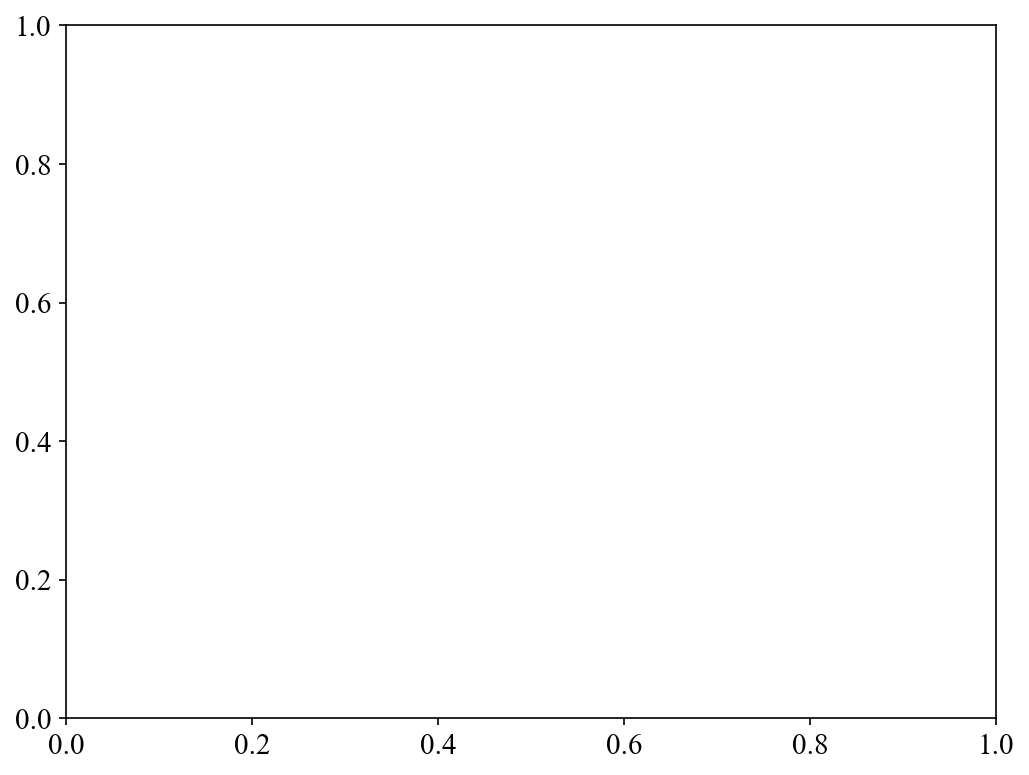

In [46]:
plt.figure(figsize=(8, 6))
hb = plt.hist2d(
    cos_sim["Difference"], 
    cos_sim["Mean Cos Sim"], 
    bins=1000, cmap="gnuplot", cmin=1.5,
)
plt.colorbar(hb[3])#, label="Count")

plt.xlabel("Difference in force magnitude prediction (QM-ANI)")
plt.ylabel("Cosine similarity between force vectors")
#plt.title("Cosine similarity vs Force magnitude prediction error")
plt.savefig('./figures/forces/2xr_comp6v1_force-cosine_sim-hist2d.png')
plt.show()

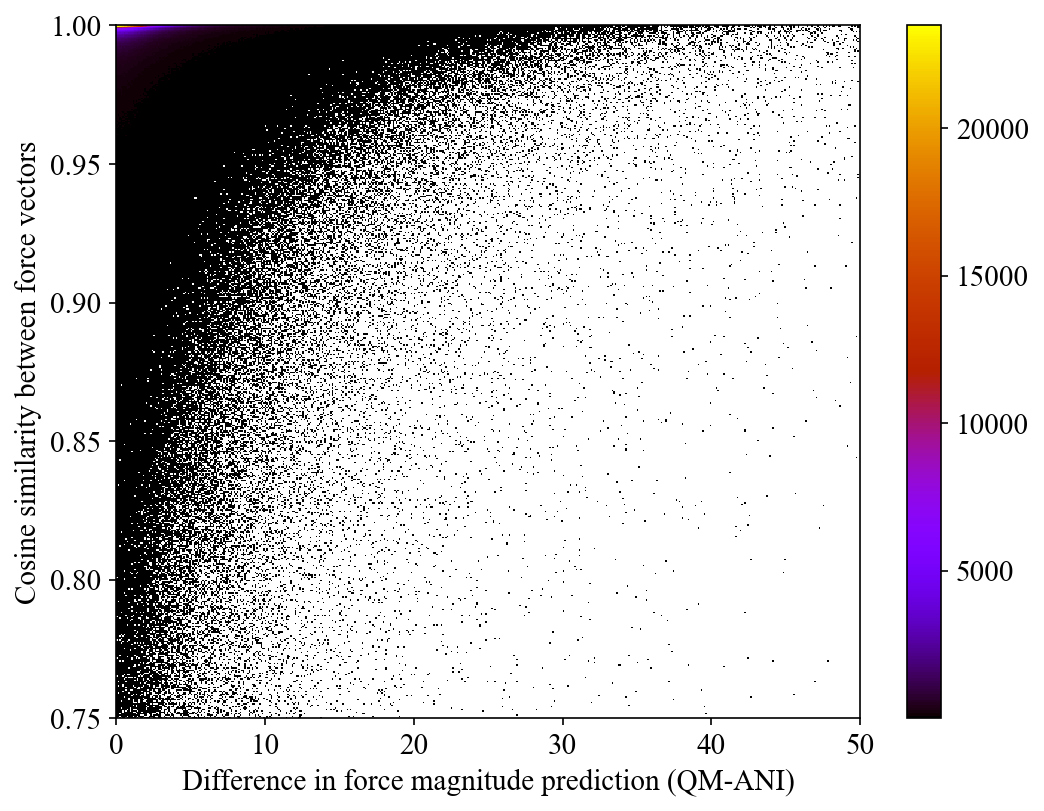

In [24]:
plt.figure(figsize=(8, 6))
hb = plt.hist2d(
    cos_sim["Difference"], 
    cos_sim["Mean Cos Sim"], 
    bins=500, cmap="gnuplot", cmin=1,
    range=[[0,50],[0.75,1]]
)
plt.colorbar(hb[3])#, label="Count")

plt.xlabel("Difference in force magnitude prediction (QM-ANI)")
plt.ylabel("Cosine similarity between force vectors")
#plt.title("Cosine similarity vs Force magnitude prediction error")
plt.show()

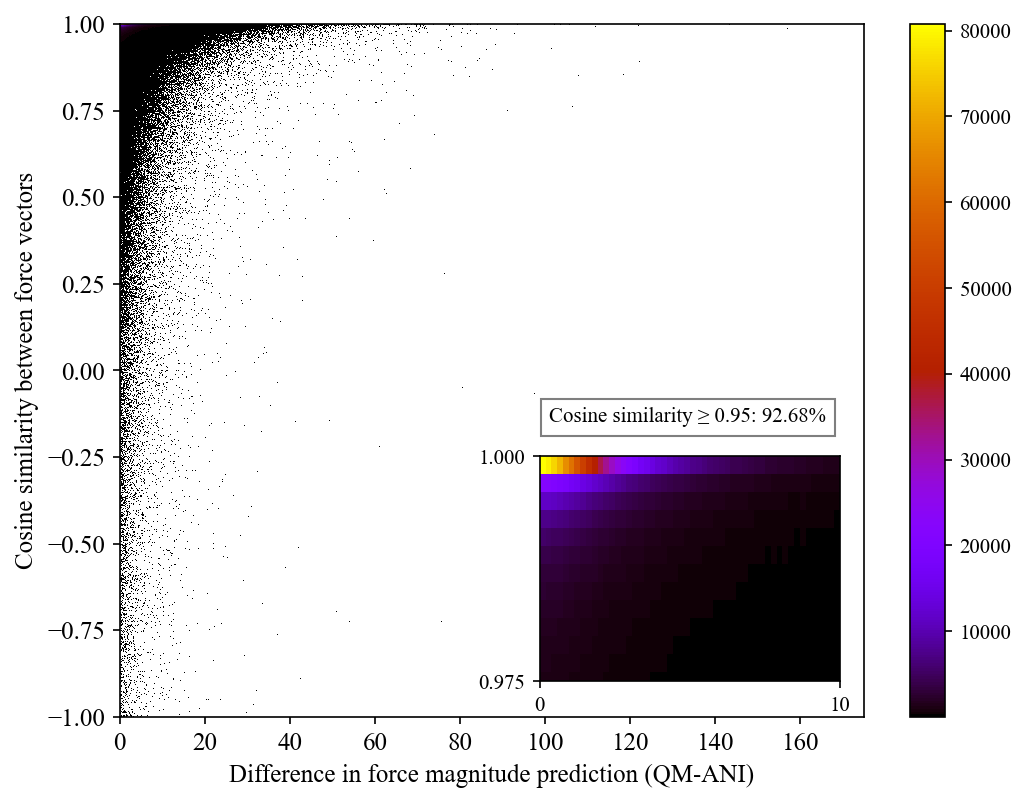

In [60]:
# Create main figure
fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams["font.size"] = 10
# Main 2D histogram
hb = ax.hist2d(
    cos_sim["Difference"], 
    cos_sim["Mean Cos Sim"], 
    range=[[0,175],[-1,1]],
    bins=1000, cmap="gnuplot", cmin=1,
)
plt.colorbar(hb[3], ax=ax)

ax.set_xlabel("Difference in force magnitude prediction (QM-ANI)")
ax.set_ylabel("Cosine similarity between force vectors")

# Inset plot for zoomed-in view
ax_inset = fig.add_axes([0.475, 0.15, 0.25, 0.25])  # Position [left, bottom, width, height]
hb_inset = ax_inset.hist2d(
    cos_sim["Difference"], 
    cos_sim["Mean Cos Sim"], 
    bins=1000, cmap="gnuplot", cmin=1,
)
ax_inset.set_xlim(0, 10)
ax_inset.set_ylim(0.975, 1)
ax_inset.set_xticks([0, 10])
ax_inset.set_yticks([0.975, 1])
#ax_inset.set_title("Zoom-in View", fontsize=10)

# Compute fraction of points with cosine similarity ~1
threshold = 0.95
frac_near_1 = (cos_sim["Mean Cos Sim"] > threshold).mean()

# Annotate fraction of points near y=1
ax.text(101, -0.15, f"Cosine similarity ≥ 0.95: {(frac_near_1.item()*100):.2f}%", fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.5))

plt.savefig('./figures/forces/cos_sim-hist2d-insert.png')
plt.show()

In [53]:
threshold = 0.95
(cos_sim["Mean Cos Sim"] > threshold).mean()

np.float64(0.9267698740215067)

In [20]:
atom_types_colors = {
    1: ("H", "#d3d3d3"),   # Light Grey
    6: ("C", "#90ee90"),   # Light Green
    7: ("N", "#add8e6"),   # Light Blue
    8: ("O", "#ffcccb")    # Light Red
}

cos_sim_plot = cos_sim.reset_index()
cos_sim_plot["Species"] = cos_sim_plot["Species"].map(lambda x: atom_types_colors.get(x, ("Unknown", "#000000"))[0])

species_color_map = {v[0]: v[1] for v in atom_types_colors.values()}


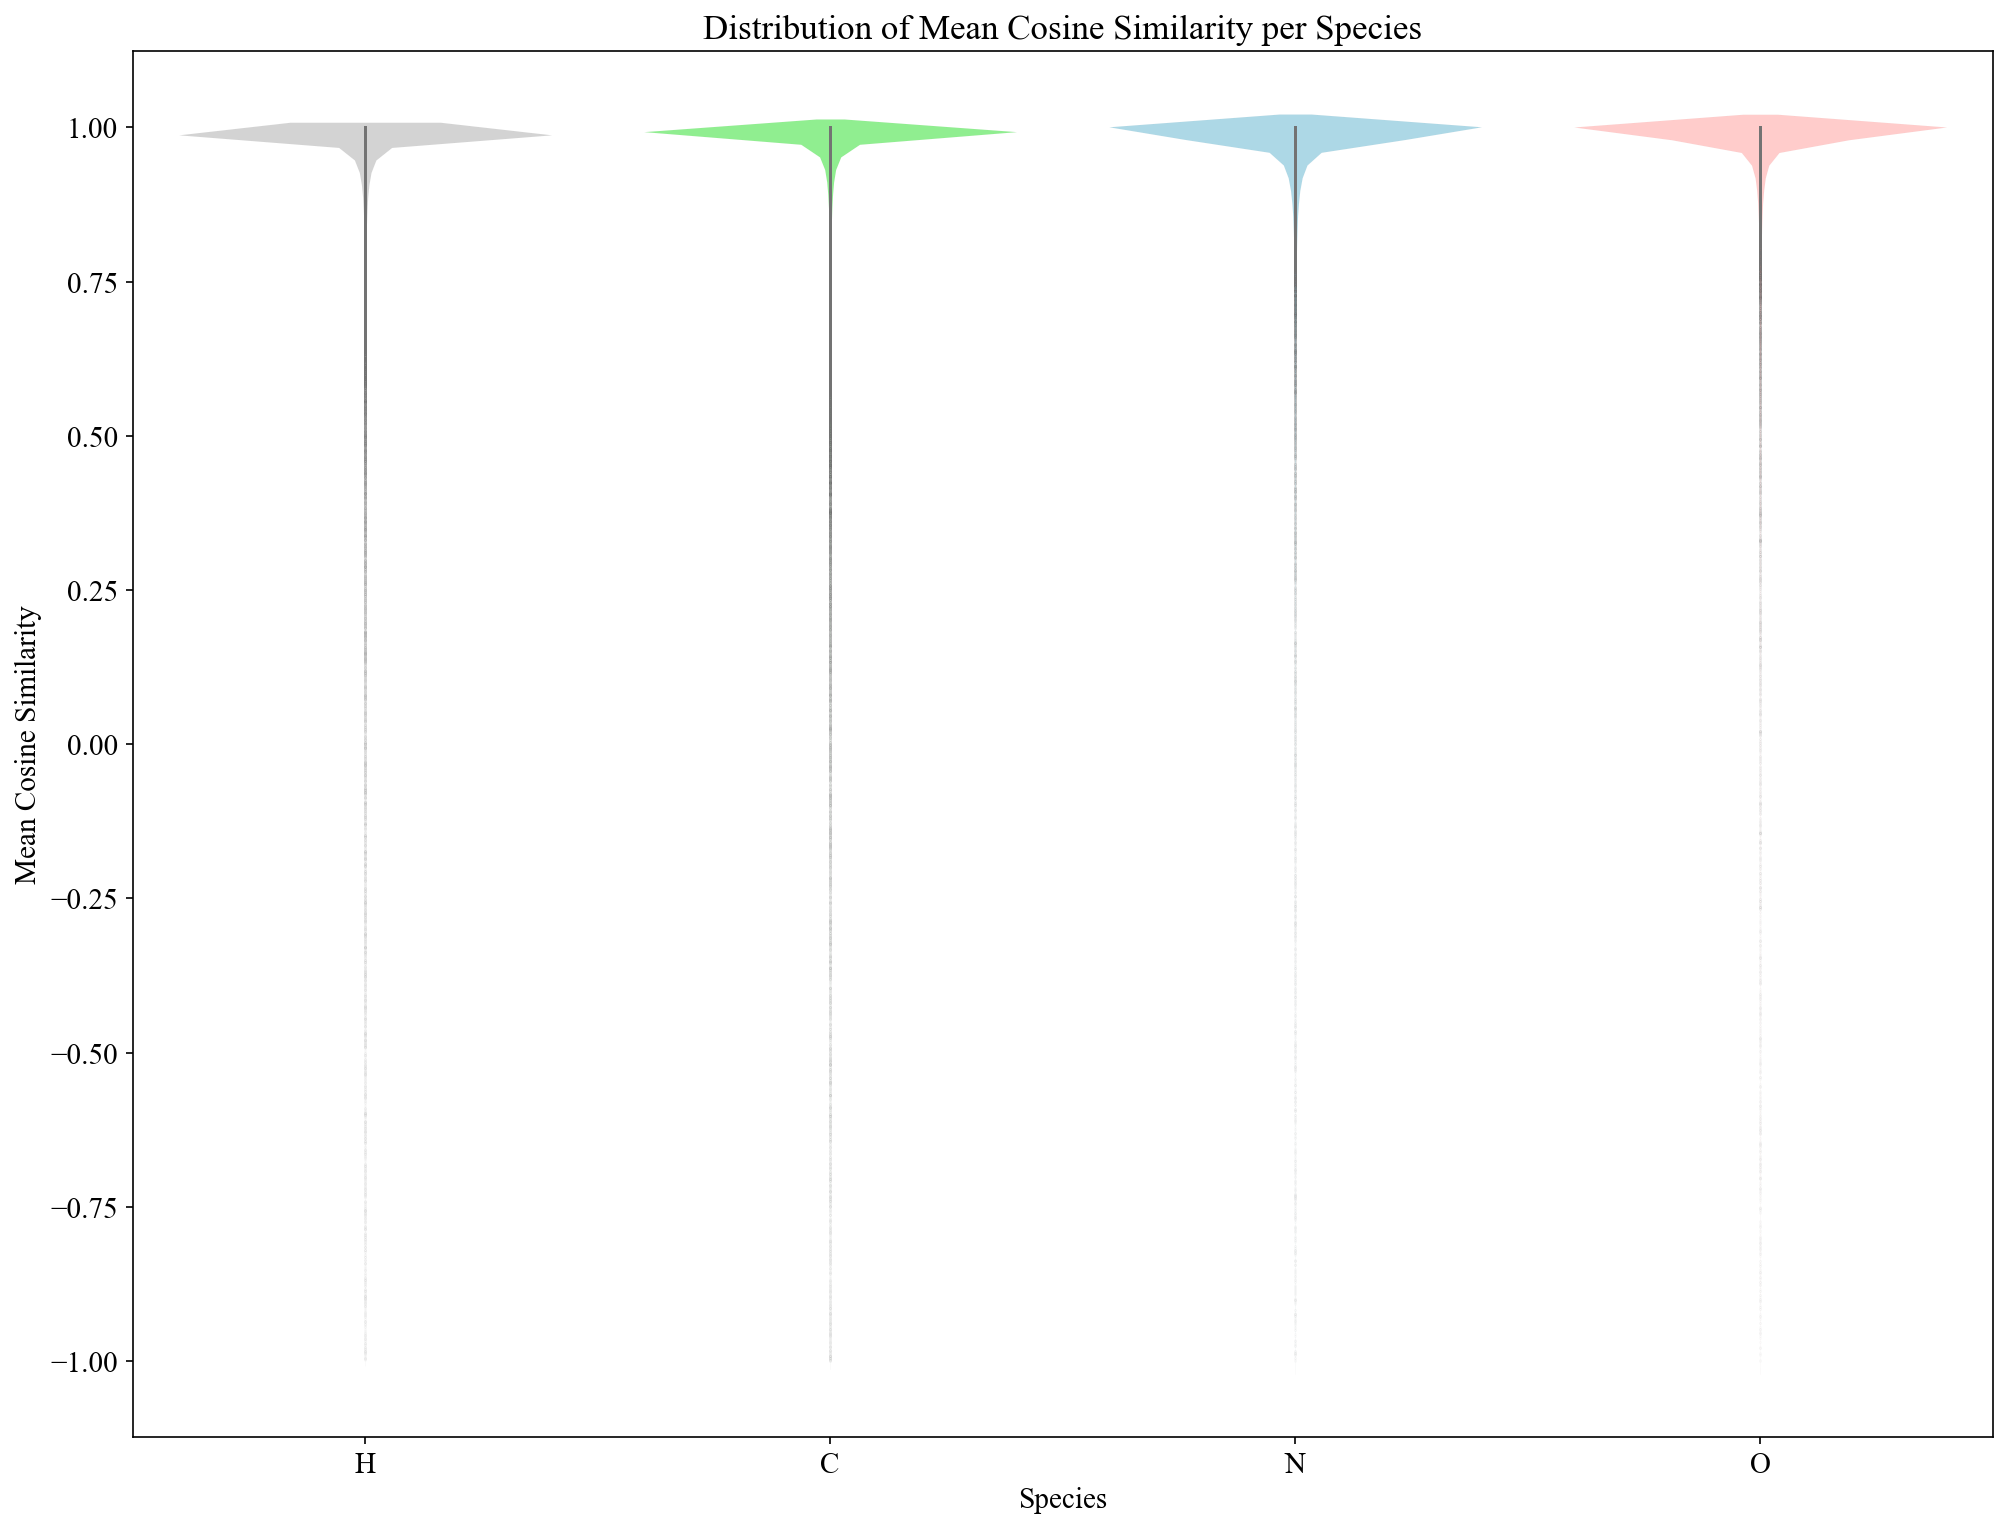

In [76]:
plt.figure(figsize=(16, 12))
sns.violinplot(data=cos_sim_plot, x="Species", y="Mean Cos Sim", inner="point", 
               hue="Species", palette=species_color_map, order=['H', 'C', 'N', 'O'], saturation=1,
               linewidth=0.005, density_norm='count', bw_adjust=1)

plt.xlabel("Species")
plt.ylabel("Mean Cosine Similarity")
plt.title("Distribution of Mean Cosine Similarity per Species")
#plt.xticks(rotation=45)  # Rotate x-axis labels if there are many species
#plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [36]:
print(len(cos_sim_plot))

2608858


In [46]:
# Create the 2D histogram
hist, xedges, yedges = np.histogram2d(
    cos_sim["Difference"], 
    cos_sim["Mean Cos Sim"], 
    bins=500
)

# Construct positions for bars
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

# Set the width and depth of bars
dx = (xedges[1] - xedges[0]) * np.ones_like(xpos)  # Bin width
dy = (yedges[1] - yedges[0]) * np.ones_like(ypos)
dz = hist.ravel()  # Histogram heights

# Filter out empty bins
nonzero = dz > 0
xpos, ypos, zpos, dx, dy, dz = xpos[nonzero], ypos[nonzero], zpos[nonzero], dx[nonzero], dy[nonzero], dz[nonzero]


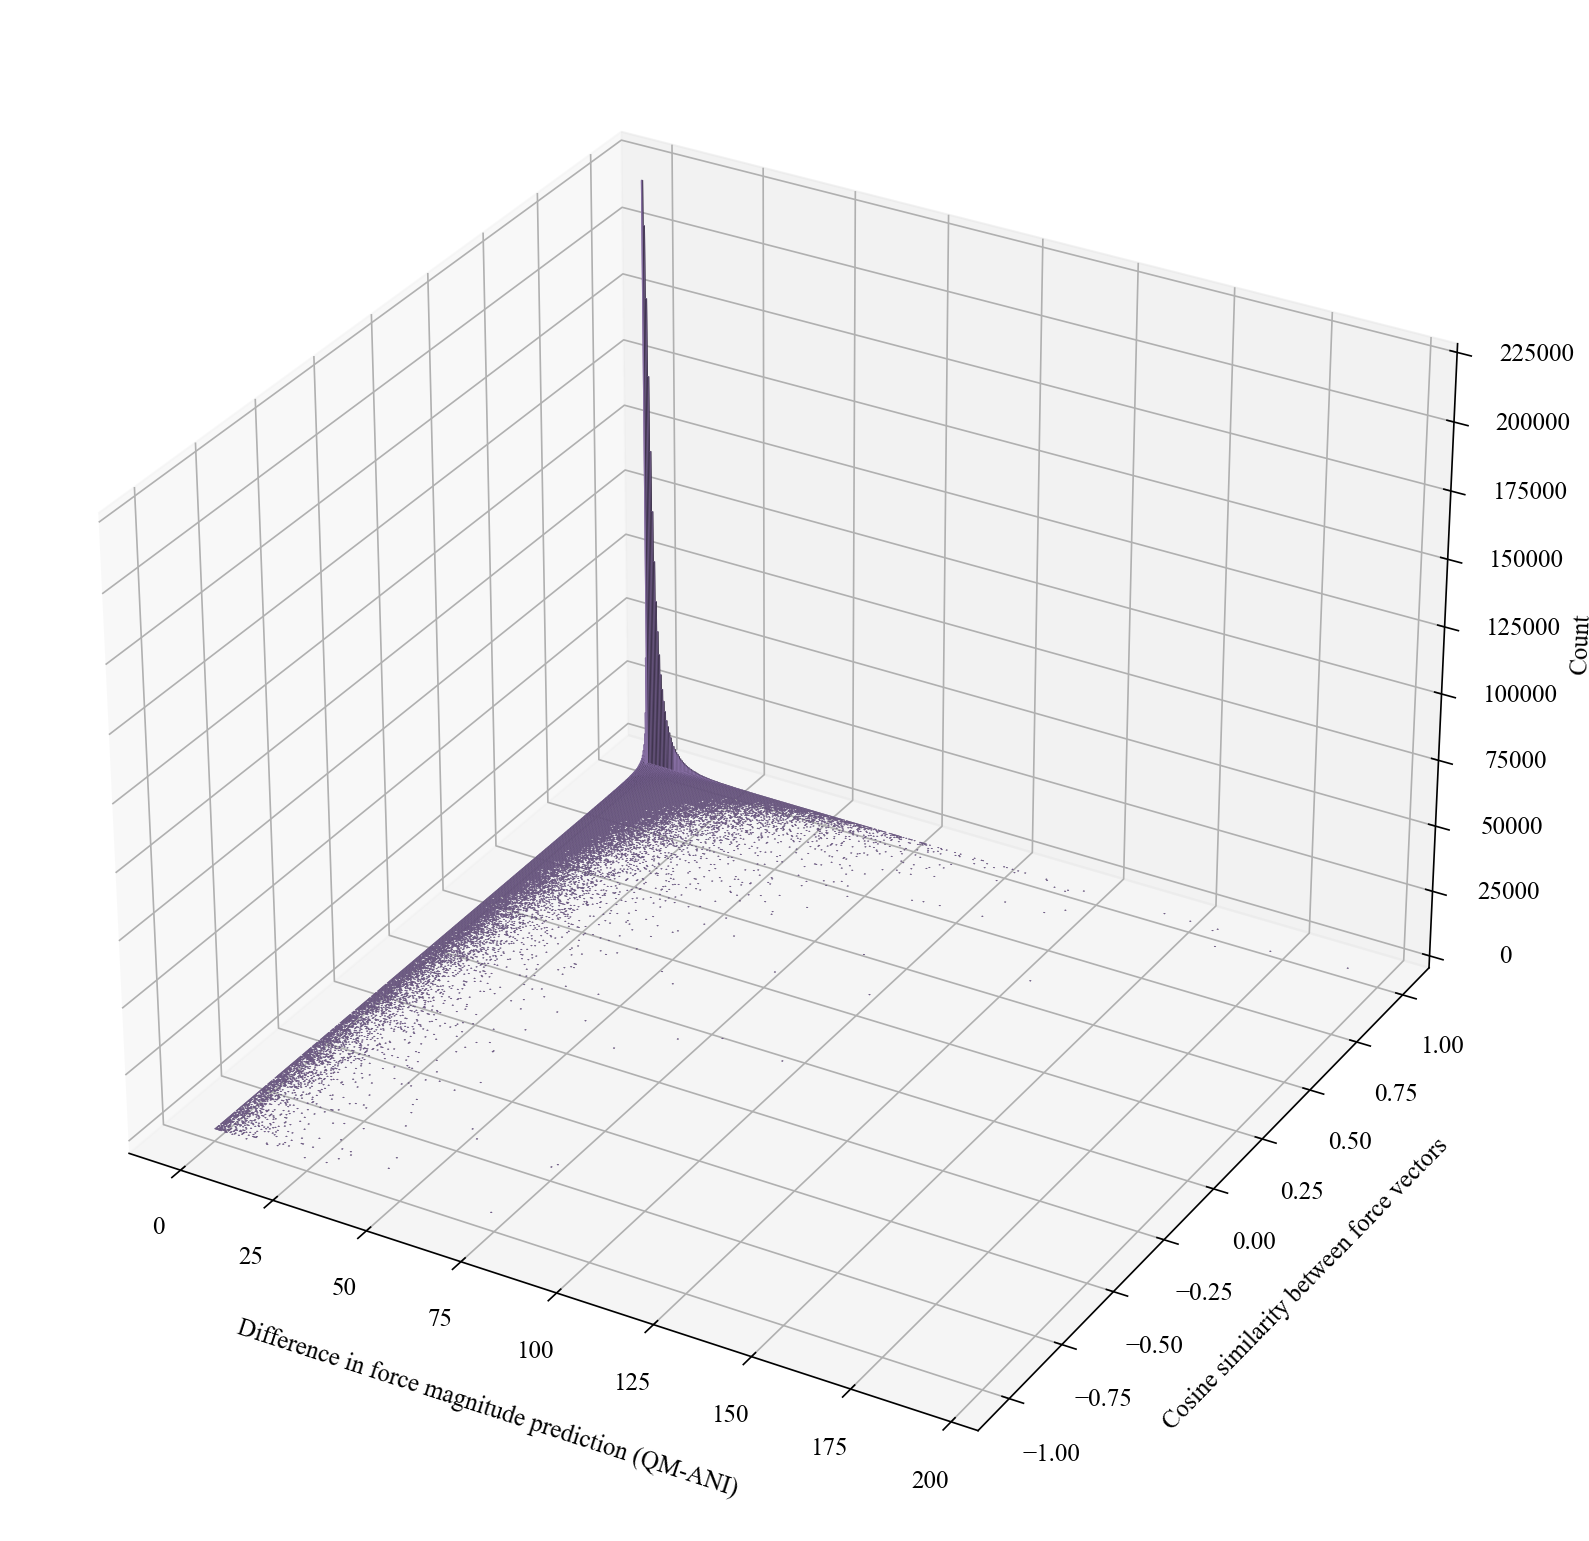

In [61]:
plt.rcParams["font.size"] = 12

fig = plt.figure(figsize=(13, 14))
ax = fig.add_subplot(111, projection='3d')

# Plot only non-empty bins
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, color="#967BB6")

# Labels and title
# Adjust label positions to avoid overlap
ax.set_xlabel("Difference in force magnitude prediction (QM-ANI)", labelpad=20)
ax.set_ylabel("Cosine similarity between force vectors", labelpad=20)
ax.set_zlabel("Count", labelpad=20)

# Adjust tick label positions
ax.xaxis.set_tick_params(pad=8)
ax.yaxis.set_tick_params(pad=10)
ax.zaxis.set_tick_params(pad=15)
#ax.set_title("3D Histogram: Cosine Similarity vs Force Magnitude Prediction Error")
plt.savefig('./figures/forces/2xr_comp6v1_force-cosine_sim-bar3d.png')
plt.show()

/var/folders/gg/d8ll1f157js5d4n67jyq89jr0000gn/T/ipykernel_50949/1488288178.py:35: UserWarning: Attempt to set non-positive zlim on a log-scaled axis will be ignored.
  ax.set_zscale("log")


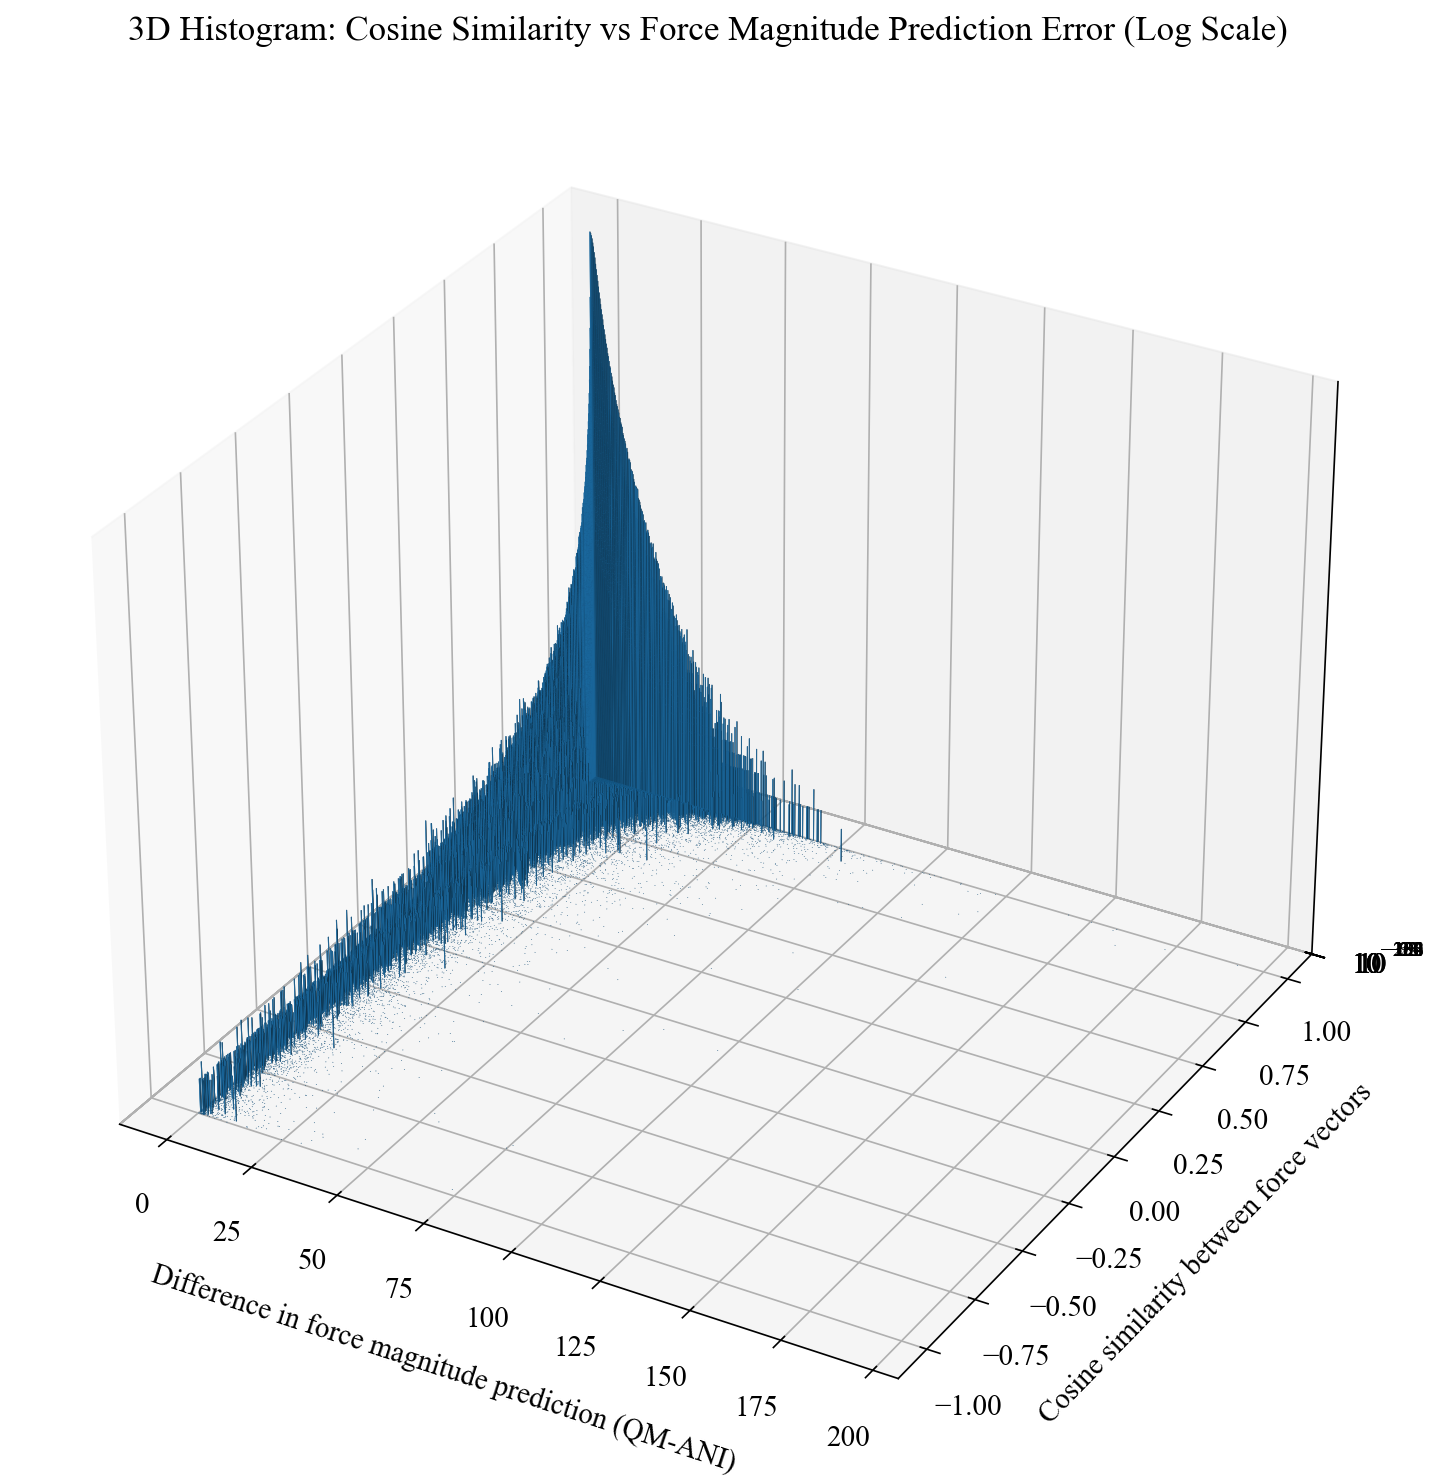

In [77]:
# Create the 2D histogram
hist, xedges, yedges = np.histogram2d(
    cos_sim["Difference"], 
    cos_sim["Mean Cos Sim"], 
    bins=1000, range=[[0,200],[-1,1]]
)

# Construct positions for bars
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

# Set the width and depth of bars
dx = (xedges[1] - xedges[0]) * np.ones_like(xpos)

dy = (yedges[1] - yedges[0]) * np.ones_like(ypos)
dz = hist.ravel()  # Histogram heights (counts)

# Filter out empty bins
nonzero = dz > 0
xpos, ypos, zpos, dx, dy, dz = xpos[nonzero], ypos[nonzero], zpos[nonzero], dx[nonzero], dy[nonzero], dz[nonzero]

# Apply log transformation to the count data
dz = np.log10(dz)

# Create figure and 3D axis
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot only non-empty bins
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)

# Set the z-axis to log scale
ax.set_zscale("log")

# Adjust label positions to avoid overlap
ax.set_xlabel("Difference in force magnitude prediction (QM-ANI)", labelpad=20)
ax.set_ylabel("Cosine similarity between force vectors", labelpad=20)
ax.set_zlabel("Log(Count)", labelpad=20)

# Adjust tick label positions
ax.xaxis.set_tick_params(pad=10)
ax.yaxis.set_tick_params(pad=10)
ax.zaxis.set_tick_params(pad=15)

# Labels and title
ax.set_title("3D Histogram: Cosine Similarity vs Force Magnitude Prediction Error (Log Scale)", pad=20)
plt.savefig('./figures/forces/2xr_comp6v1_force-cosine_sim-bar3d-logscale.png')
plt.show()